### Check Conversion

In this Notebook we will do a basic data quality check of the conversion, we will also see the immense difference in speed and data accessibility between geodatabases(standard geospatial datastructures) and ARCO formats.

The ability to subset specifically what we are looking for, and where we are looking for it without having to download a whole zip file and then open a larger vector dataset.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import random
from shapely.geometry import Point
import xarray as xr
import rasterio
from rasterstats import zonal_stats

In [2]:
# Open GeoTIFF
with rasterio.open('zipfiles/baltic_secchi_disk_depth_ratio/baltic_secchi_disk_depth_ratio.tif') as src:
    img = src.read(1)

In [4]:
# Open zarr dataset
ds = xr.open_zarr('secchi_disk_water_depth_ratio.zarr')
# Choose secchi_disk_water_depth_ratio variable
var = ds['secchi_disk_water_depth_ratio'].sel(band=1)
print(var)

<xarray.DataArray 'secchi_disk_water_depth_ratio' (latitude: 8321,
                                                   longitude: 22043)> Size: 1GB
dask.array<getitem, shape=(8321, 22043), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    band       int64 8B 1
  * latitude   (latitude) float64 67kB 48.53 48.53 48.53 ... 66.57 66.57 66.57
  * longitude  (longitude) float64 176kB -13.45 -13.45 -13.45 ... 34.34 34.34
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_COVARIANCES:  45.2653131290138
    STATISTICS_MAXIMUM:      1115.955078125
    STATISTICS_MEAN:         8.5584246713118
    STATISTICS_MINIMUM:      -1409.4304199219
    STATISTICS_STDDEV:       6.7279501431724
    grid_mapping:            spatial_ref


### Compare Geotiff with Zarr

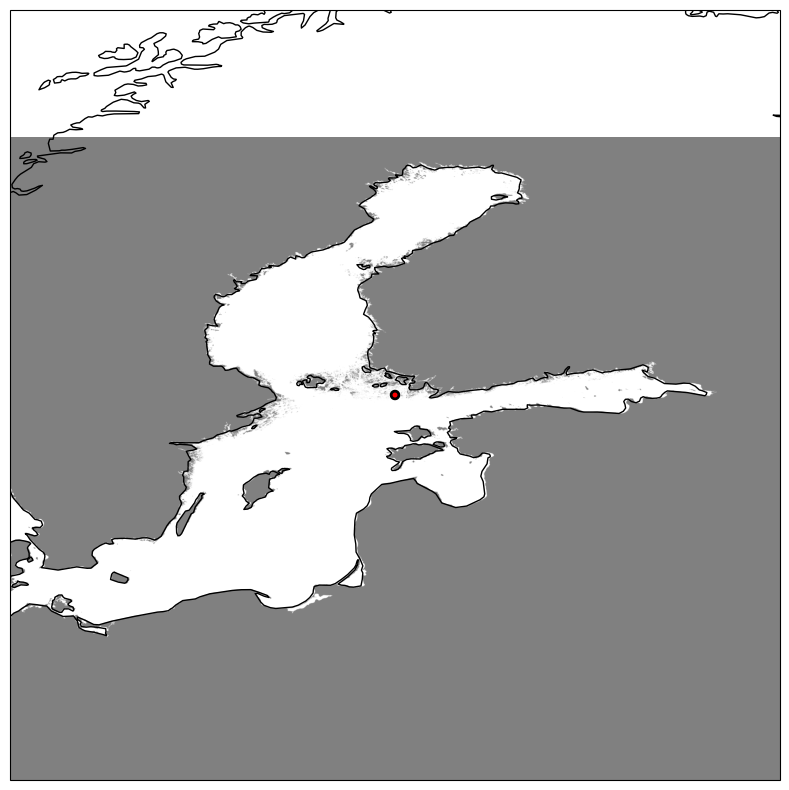

In [11]:
# Create a boolean mask where the variable is not NaN
mask = ~np.isnan(var.values)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.imshow(mask, origin='lower', transform=ccrs.PlateCarree(), cmap='gray', alpha=0.5, 
          extent=[var['longitude'].min(), var['longitude'].max(), var['latitude'].min(), var['latitude'].max()])

idx = np.where(~np.isnan(var.values))
lat_idx = idx[0]
lon_idx = idx[1]
# Choose a random index from the length of idx[0]
random_index = np.random.choice(len(idx[0]))
# Use the random index to get corresponding latitude and longitude
lat_start1 = var['latitude'].values[lat_idx[random_index]]
lon_start1 = var['longitude'].values[lon_idx[random_index]]

# Reduce the size of the circle if necessary
circle = Point(lon_start1, lat_start1).buffer(0.1)  # Adjust the buffer size as needed
# Add a circle to highlight the slice
circle_patch = plt.Polygon(np.array(circle.exterior.xy).T, facecolor='red', edgecolor='black', lw=2)
ax.add_patch(circle_patch)

# Zoom in to the circle
ax.set_xlim([lon_start1 - 10, lon_start1 + 10])
ax.set_ylim([lat_start1 - 10, lat_start1 + 10])

plt.show()

-3.4028234663852886e+38
The majority of the data inside the circle is: -3.4028234663852886e+38


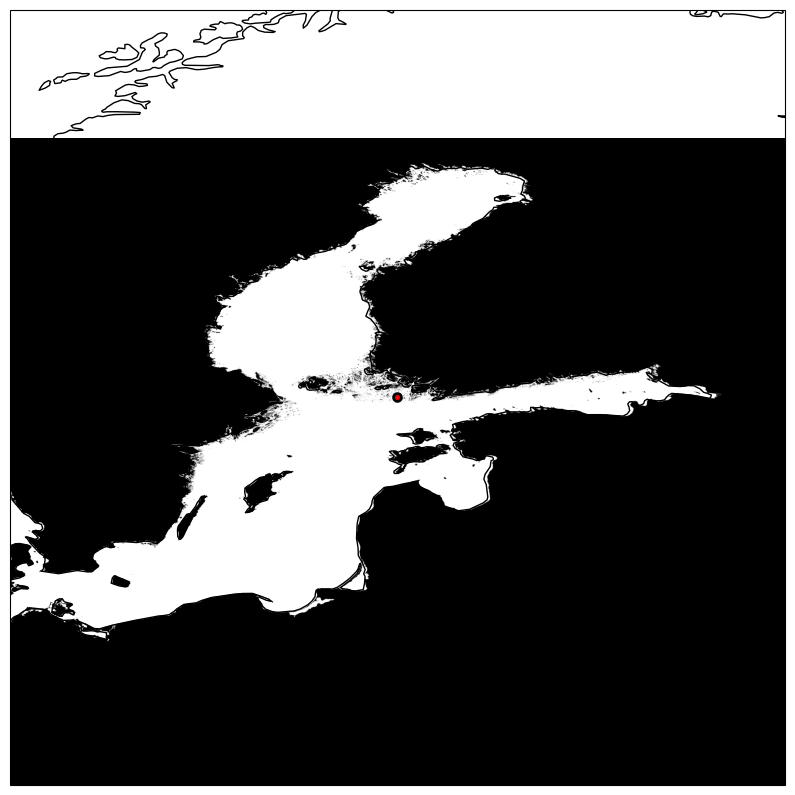

In [12]:
# Plot the same circle on the GeoTIFF and look for the mode of values in that circle buffer

# Intersect the circle with the GeoTIFF
stats = zonal_stats(circle, img, affine=src.transform, stats="majority")

majority_value = stats[0]['majority']

print(majority_value)
print(f"The majority of the data inside the circle is: {majority_value}")

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.imshow(np.flipud(img), cmap='gray', origin='lower', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
ax.coastlines()

# Add a circle to highlight the slice
circle_patch = plt.Polygon(np.array(circle.exterior.xy).T, facecolor='red', edgecolor='black', lw=2)
ax.add_patch(circle_patch)

# Zoom in to the circle
ax.set_xlim([lon_start1 - 10, lon_start1 + 10])
ax.set_ylim([lat_start1 - 10, lat_start1 + 10])

plt.show()

In [13]:
# Get the value from the Zarr dataset at the chosen point
zarr_value = var.sel(latitude=lat_start1, longitude=lon_start1).values
print(f"Zarr value at the point ({lon_start1}, {lat_start1}): {zarr_value}")

Zarr value at the point (22.072609887346374, 59.893472243000694): 3.807760238647461


In [14]:
# Get the value from the GeoTIFF at the chosen point
row, col = src.index(lon_start1, lat_start1)
tif_value = img[row, col]
print(f"GeoTIFF value at the point ({lon_start1}, {lat_start1}): {tif_value}")

GeoTIFF value at the point (22.072609887346374, 59.893472243000694): 3.807760238647461


In [15]:
# Compare the values
if np.isclose(zarr_value, tif_value):
    print("The values from the Zarr dataset and the GeoTIFF file at the chosen point are the same.")
else:
    print("The values from the Zarr dataset and the GeoTIFF file at the chosen point are not the same.")

The values from the Zarr dataset and the GeoTIFF file at the chosen point are the same.
